In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the datasets

In [2]:
# gdown

In [3]:
scrna = sc.read('../data/sagner-2021/expressions_hvg.h5ad')
scrna

AnnData object with n_obs × n_vars = 6334 × 4000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'count'

In [4]:
#gdown

In [5]:
scatac = sc.read('../data/sagner-2021/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 6334 × 38313
    obs: 'nb_features', 'cell_type', 'batch'
    var: 'feature_types', 'genome', 'gene_ids-0', 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'gene_ids-1', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    layers: 'binary'

In [6]:
scrna1 = scrna[scrna.obs['batch'] == '0']
scrna2 = scrna[scrna.obs['batch'] == '1']

In [7]:
scatac1 = scatac[scatac.obs['batch'] == '0']
scatac2 = scatac[scatac.obs['batch'] == '1']

# Configure and train the model

In [36]:
model = mtg.models.MultiVAE(
    adatas=[[scrna1, scrna2], [scatac1, scatac2]],
    names=[['RNA-batch1', 'RNA-batch2'], ['ATAC-batch1', 'ATAC-batch2']],
    pair_groups=[[0, 1], [0, 1]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'leakyrelu'],
    losses=['nb', 'mse'],
    layers=[['count', 'count'], [None, None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-4,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [37]:
model.train(
    n_iters=5000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=1500,
    validate_every=500,
    verbose=1
)

 |████████████████████| 100.0% iter=5000/5000, time=33.76(s), loss=0.2945, recon=0.2937, kl=79.8711, integ=0.0127, cycle=0.0000, val_loss=0.2964, val_recon=0.2958, val_kl=61.8486, val_integ=0.0411, val_cycle=0.0000

### Plot training history

In [38]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,500,0.327035,0.326954,34.840666,0.012004,0.0,0.300882,0.300743,40.402813,0.039877,0
1,1000,0.302655,0.302329,59.531403,0.034572,0.0,0.298547,0.298219,48.610912,0.041303,0
2,1500,0.299540,0.298932,69.932486,0.012261,0.0,0.297627,0.297057,56.607330,0.040947,0
3,2000,0.297951,0.297229,72.116061,0.012863,0.0,0.297052,0.296424,62.331497,0.042351,0
4,2500,0.291974,0.291238,73.162790,0.035666,0.0,0.296941,0.296367,57.056820,0.041116,0
5,3000,0.297130,0.296374,75.535381,0.012388,0.0,0.296743,0.296113,62.632191,0.042110,0
6,3500,0.284191,0.283422,76.458284,0.037237,0.0,0.296751,0.296197,54.955956,0.041206,0
7,4000,0.296260,0.295483,77.524361,0.012997,0.0,0.296461,0.295827,62.942299,0.042116,0
8,4500,0.279942,0.279150,78.906836,0.037349,0.0,0.296644,0.296077,56.271702,0.040045,0
9,4999,0.294504,0.293704,79.871143,0.012694,0.0,0.296392,0.295769,61.848595,0.041062,0


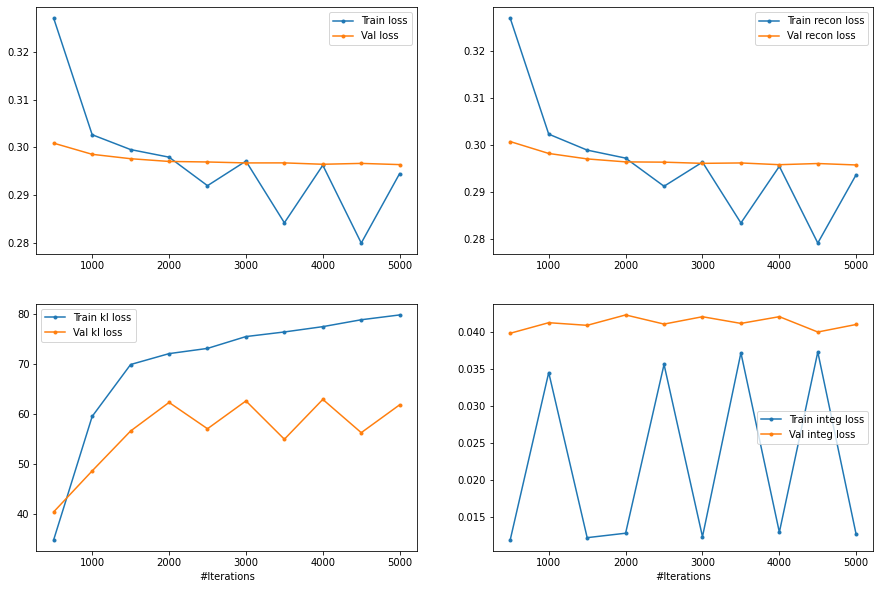

In [39]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

## UMAP plot of the latent space

In [40]:
z = model.predict(
    adatas=[[scrna1, scrna2], [scatac1, scatac2]],
    names=[['RNA-batch1', 'RNA-batch2'], ['ATAC-batch1', 'ATAC-batch2']],
    pair_groups=[[0, 1], [0, 1]],
    batch_size=256,
    layers=[['count', 'count'], [None, None]]
)
z

AnnData object with n_obs × n_vars = 6334 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [41]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


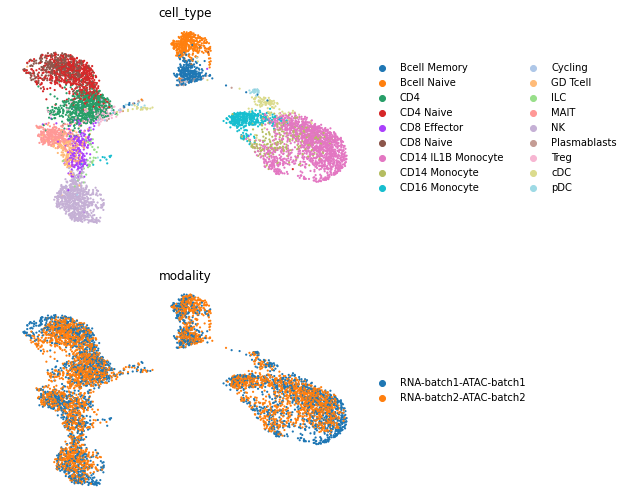

In [42]:
sc.pl.umap(z, color=['cell_type', 'modality'], ncols=1, frameon=False)

In [43]:
z.write('../data/integrated/multigrate/sagner-multigrate.h5ad')

# Remove unnecessary files

In [44]:
# todo